# Histogram Equalization

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [1]:
%cd /tf/notebooks

/tf/notebooks


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from preprocessing import equalize_image


import cv2
from deepface import DeepFace


In [4]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = preprocessing(path)
        img = resize(img,shape)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

## Example

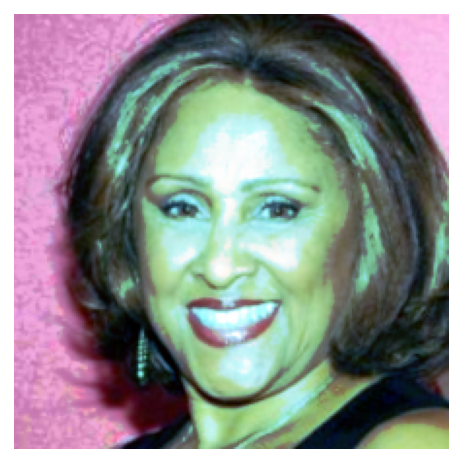

In [5]:
indian_img_path = pd.read_pickle("results/arcface/African/result_dict1.pickle")["data"][337:338].original_image.values[0]

indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = equalize_image)
plt.imshow(indian_img)
plt.axis('off');

In [ ]:
plt.hist(indian_img.flatten(), color = 'r',bins=125);

In [ ]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img)
plt.axis('off');

In [ ]:
plt.hist(indian_img.flatten(),256,[0,256], color = 'r');

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [ ]:
facenet_model = "facenet_histogram_equalization"

In [ ]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

In [ ]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

In [ ]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [ ]:
vgg_face_model = "vgg_face_histogram_equalization"

In [ ]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

In [ ]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

In [ ]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [ ]:
arcface_model = "arcface_histogram_equalization"

In [ ]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

In [ ]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

In [ ]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

In [ ]:
plot_score_distribution(facenet_model)

In [ ]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [ ]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


In [ ]:
plot_score_distribution(vgg_face_model)

In [ ]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [ ]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

In [ ]:
plot_score_distribution(arcface_model)

In [ ]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [ ]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [ ]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [ ]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [ ]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [ ]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [ ]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [ ]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [ ]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = equalize_image)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = equalize_image)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = equalize_image)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = equalize_image)

In [ ]:
facenet512 = DeepFace.build_model("Facenet512")

In [ ]:
plot_face_heatmap(facenet512, african_img)

In [ ]:
plot_face_heatmap(facenet512, asian_img)

In [ ]:
plot_face_heatmap(facenet512, caucasian_img)

In [ ]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [ ]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = equalize_image)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = equalize_image)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = equalize_image)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = equalize_image)

In [ ]:
vgg_face = DeepFace.build_model("VGG-Face")

In [ ]:
plot_face_heatmap(vgg_face, african_img)

In [ ]:
plot_face_heatmap(vgg_face, african_img)

In [ ]:
plot_face_heatmap(vgg_face, asian_img)

In [ ]:
plot_face_heatmap(vgg_face, caucasian_img)

In [ ]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [ ]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = equalize_image)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = equalize_image)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = equalize_image)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = equalize_image)

In [ ]:
arcface = DeepFace.build_model("ArcFace")

In [ ]:
plot_face_heatmap(arcface, african_img)

In [ ]:
plot_face_heatmap(arcface, asian_img)

In [ ]:
plot_face_heatmap(arcface, caucasian_img)

In [ ]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others